# Set-Up and Imports

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import surrojax_gp
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import itertools
from arraytainers import Arraytainer
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Plotting settings:

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# dpi of images saved to seperate folder:
mpl_save_dpi = 300
# Plot theme:
sns.set_theme(style='darkgrid')
palette = sns.color_palette()

y-limits of APE plots:

In [3]:
ape_ylims = (-1.6, -0.6)

Save directory for figures:

In [4]:
fig_save_dir = './figs/noise_prior'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

Random seeds:

In [5]:
jax_rng = jax.random.PRNGKey(42)
np_seed = 42

# Effect of Noise

For the purposes of playing around with noise and the prior, we'll stick with our local linearisation posterior since it performed the best. Let's now load our beam model and create a minimiser for our Laplace approximation:

In [10]:
beam_gp = surrojax_gp.load_gp('../chapter_4/nonlinear_beam_gp.json')
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
minimizer = oed_toolbox.optim.gradient_descent_for_map()

Let's now plot the APE landscape for different amounts of noise:

In [57]:
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
num_samples = 1000
noise_cov_list = jnp.linspace(0.001, 0.01, 10)
d_vals = jnp.linspace(0,1,50)
ape_noise = []
for noise_cov in noise_cov_list:
    print(f'Computing APE loss landscape for noise_cov = {noise_cov}')
    likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
    laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, 
                                                                               noise_cov, prior_mean, prior_cov)
    laplace_ape = oed_toolbox.losses.APE(prior, likelihood, laplace_approx, use_reparameterisation=True)
    ape_vals = []
    for i, d in enumerate(d_vals):
        ape_vals.append(laplace_ape(d, num_samples=num_samples, rng=np.random.default_rng(np_seed), return_grad=False))
    ape_noise.append(ape_vals)

noise_experiment = {'noise_cov': noise_cov_list, 'd': d_vals, 'ape': ape_noise}
with open('ape_noise.json', 'w') as f:
    json.dump(Arraytainer(noise_experiment).tolist(), f, indent=4)

Computing APE loss landscape for noise_cov = 0.0010000000474974513
Computing APE loss landscape for noise_cov = 0.0020000000949949026
Computing APE loss landscape for noise_cov = 0.003000000026077032
Computing APE loss landscape for noise_cov = 0.004000000189989805
Computing APE loss landscape for noise_cov = 0.004999999888241291
Computing APE loss landscape for noise_cov = 0.006000000052154064
Computing APE loss landscape for noise_cov = 0.007000000216066837
Computing APE loss landscape for noise_cov = 0.00800000037997961
Computing APE loss landscape for noise_cov = 0.009000000543892384
Computing APE loss landscape for noise_cov = 0.009999999776482582


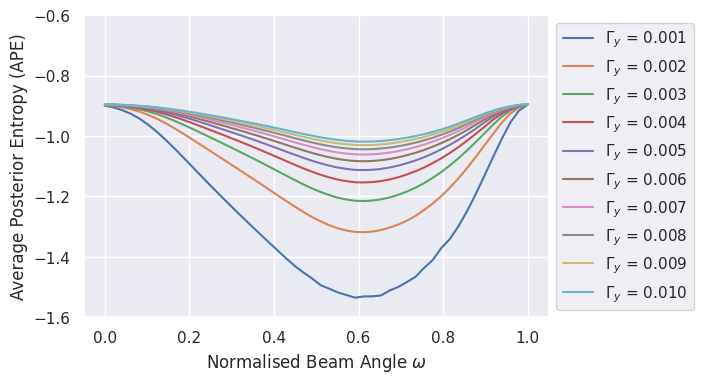

In [8]:
with open('ape_noise.json', 'r') as f:
    noise_experiment = json.load(f)

fig, ax = plt.subplots()
for i, (noise_cov, ape_i) in enumerate(zip(noise_experiment['noise_cov'], noise_experiment['ape'])):
    sns.lineplot(x=np.array(noise_experiment['d']).squeeze(), y=np.array(ape_i).squeeze(), 
                 color=palette[i], label=f'$\Gamma_y$ = {noise_cov:.3f}')
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
ax.set_ylim(*ape_ylims)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(fig_save_dir, 'noise_effect.png'), dpi=mpl_save_dpi, bbox_inches='tight')

Let's see how badly the performance of gradient descent 'degrades' on the lowest vs highest noise

# Effect of Prior

We need to be careful when changing our prior - if we're not, we could sample in regions where our surrogate is exptrapolating.

In [6]:
prior_cov_list= jnp.linspace(0.005, 0.015, 10)
prior_mean_list = jnp.linspace(0.3, 0.7, 10)
prior_combos = list(itertools.product(prior_mean_list, prior_cov_list))

Let's check to see how much the widest priors near the boundaries of the $[0, 1]$ 'poke out':

/tmp/ipykernel_7801/3971219235.py:18: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


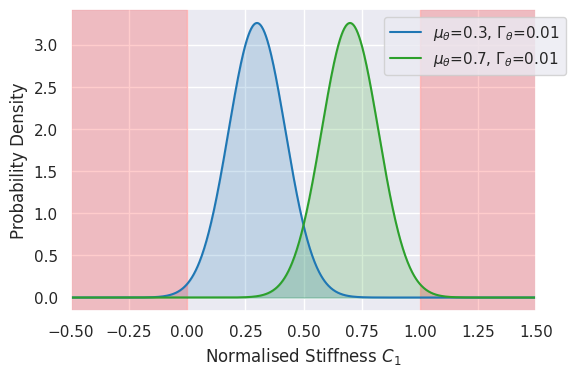

In [7]:
prior_low = oed_toolbox.distributions.Prior.gaussian(prior_mean_list[0], prior_cov_list[-1])
prior_high = oed_toolbox.distributions.Prior.gaussian(prior_mean_list[-1], prior_cov_list[-1])
theta_plot = jnp.linspace(-0.5, 1.5, 1000).reshape(-1,1)

logpdf_1 = prior_low.logpdf(theta_plot)['logpdf']
logpdf_2 = prior_high.logpdf(theta_plot)['logpdf']
pdfs = \
{f'$\\mu_\\theta$={prior_mean_list[0]:.1f}, $\\Gamma_\\theta$={prior_cov_list[-1]:.2f}': jnp.exp(logpdf_1),
 f'$\\mu_\\theta$={prior_mean_list[-1]:.1f}, $\\Gamma_\\theta$={prior_cov_list[-1]:.2f}': jnp.exp(logpdf_2)}
plotting_helpers.plot_distributions(pdfs, theta_plot, xlabel='Normalised Stiffness $C_1$', color_idx=[0,2])
ax = plt.gca()
# Highlight extrapolation regions:
ax.axvspan(-0.5, 0, alpha=0.2, color='red')
ax.axvspan(1, 1.5, alpha=0.2, color='red')
ax.set_xlim(-0.5, 1.5)
# Slightly shift legend to the right
leg = plt.legend(loc='upper right')
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = 0.08
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
plt.savefig(os.path.join(fig_save_dir, 'prior_bounds_check.png'), dpi=mpl_save_dpi, bbox_inches='tight')

Although these priors force our GP to extrapolate, it doesn't appear that it's doing this excessively. Let's now compute each loss landscape for each prior

In [10]:
noise_cov = 0.005
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
num_samples = 1000
d_vals = jnp.linspace(0,1,50)
ape_prior, prior_means, prior_covs = [], [], []
for i, (prior_mean, prior_cov) in enumerate(prior_combos):
    print(f'Computing APE loss landscape for prior {i+1}/{len(prior_combos)} (mean = {prior_mean:.2f}, cov = {prior_cov:.4f})')
    prior_means.append(prior_mean)
    prior_covs.append(prior_cov)
    prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
    laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, 
                                                                               noise_cov, prior_mean, prior_cov)
    laplace_ape = oed_toolbox.losses.APE(prior, likelihood, laplace_approx, use_reparameterisation=True)
    ape_vals = []
    for i, d in enumerate(d_vals):
        ape_vals.append(laplace_ape(d, num_samples=num_samples, rng=np.random.default_rng(np_seed), return_grad=False))
    ape_prior.append(ape_vals)

prior_experiment = {'mean': prior_means, 'cov': prior_covs, 'ape': ape_prior, 'd': d_vals}
with open('ape_prior.json', 'w') as f:
    json.dump(Arraytainer(prior_experiment).tolist(), f, indent=4)

Computing APE loss landscape for prior 1/100 (mean = 0.30, cov = 0.0050)
Computing APE loss landscape for prior 2/100 (mean = 0.30, cov = 0.0061)
Computing APE loss landscape for prior 3/100 (mean = 0.30, cov = 0.0072)
Computing APE loss landscape for prior 4/100 (mean = 0.30, cov = 0.0083)
Computing APE loss landscape for prior 5/100 (mean = 0.30, cov = 0.0094)
Computing APE loss landscape for prior 6/100 (mean = 0.30, cov = 0.0106)
Computing APE loss landscape for prior 7/100 (mean = 0.30, cov = 0.0117)
Computing APE loss landscape for prior 8/100 (mean = 0.30, cov = 0.0128)
Computing APE loss landscape for prior 9/100 (mean = 0.30, cov = 0.0139)
Computing APE loss landscape for prior 10/100 (mean = 0.30, cov = 0.0150)
Computing APE loss landscape for prior 11/100 (mean = 0.34, cov = 0.0050)
Computing APE loss landscape for prior 12/100 (mean = 0.34, cov = 0.0061)
Computing APE loss landscape for prior 13/100 (mean = 0.34, cov = 0.0072)
Computing APE loss landscape for prior 14/100 (

First, let's fix the mean and plot the effect of changing the covariance:

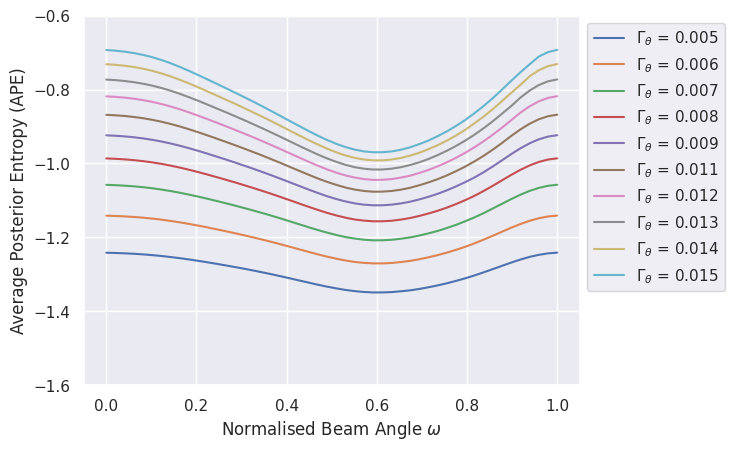

In [160]:
with open('ape_prior.json', 'r') as f:
    prior_experiment = json.load(f)

mean_idx_to_plot = 5
plot_freq = 1
fig, ax = plt.subplots()
num_plotted = num_found = 0
mean_to_plot = np.unique(prior_experiment['mean'])[mean_idx_to_plot]
for i, mean in enumerate(prior_experiment['mean']):
    if np.isclose(mean, mean_to_plot):
        if num_found % plot_freq == 0:
            ape_i = np.array(prior_experiment['ape'])[i,:]
            prior_cov = prior_experiment['cov'][i]
            sns.lineplot(x=np.array(prior_experiment['d']).squeeze(), y=ape_i.squeeze(), 
                         color=palette[num_plotted], label=f'$\Gamma_\\theta$ = {prior_cov:.3f}')
            num_plotted += 1
        num_found += 1
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
plt.legend(bbox_to_anchor=(1,1))
ax.set_ylim(*ape_ylims)
plt.savefig(os.path.join(fig_save_dir, 'prior_cov_effect.png'), dpi=mpl_save_dpi, bbox_inches='tight')

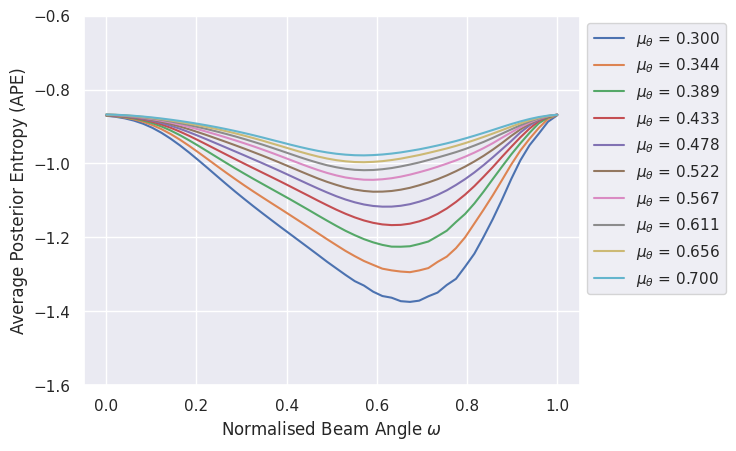

In [159]:
with open('ape_prior.json', 'r') as f:
    prior_experiment = json.load(f)

cov_idx_to_plot = 5
plot_freq = 1
fig, ax = plt.subplots()
num_plotted = num_found = 0
cov_to_plot = np.unique(prior_experiment['cov'])[cov_idx_to_plot]
for i, cov in enumerate(prior_experiment['cov']):
    if np.isclose(cov, cov_to_plot):
        if num_found % plot_freq == 0:
            ape_i = np.array(prior_experiment['ape'])[i,:]
            prior_mean = prior_experiment['mean'][i]
            sns.lineplot(x=np.array(prior_experiment['d']).squeeze(), y=ape_i.squeeze(), 
                         color=palette[num_plotted], label=f'$\mu_\\theta$ = {prior_mean:.3f}')
            num_plotted+=1
        num_found += 1
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
plt.legend(bbox_to_anchor=(1,1))
ax.set_ylim(*ape_ylims)
plt.savefig(os.path.join(fig_save_dir, 'prior_mean_effect.png'), dpi=mpl_save_dpi, bbox_inches='tight')

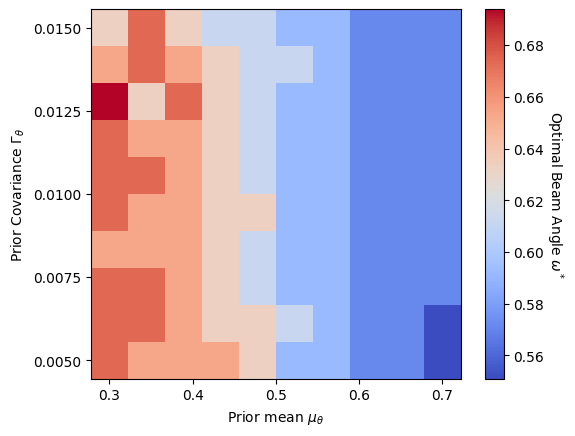

In [153]:
grid_len = 10
oed_list = []
d_vals = prior_experiment['d']
for ape_i in prior_experiment['ape']:
    smallest_ape_idx = np.argsort(ape_i)[0]
    oed_list.append(d_vals[smallest_ape_idx])
oed = np.array(oed_list).reshape(grid_len,grid_len,order='F')
x_grid = np.array(prior_experiment['mean']).reshape(grid_len, grid_len)
y_grid = np.array(prior_experiment['cov']).reshape(grid_len,grid_len)
plt.rcdefaults()
fig, ax = plt.subplots()
im = plt.imshow(oed, cmap='coolwarm', origin='lower')
cbar = plt.colorbar(im)
cbar.set_label('Optimal Beam Angle $\omega^*$', rotation=270, labelpad=15)
plotting_helpers.set_x_and_y_ticks(ax, x_grid, y_grid, num_x_ticks=5, num_y_ticks=5, x_dp=1, y_dp=4)
ax.set_xlabel('Prior mean $\mu_\\theta$')
ax.set_ylabel('Prior Covariance $\Gamma_\\theta$')
sns.set_theme(style='darkgrid')
plt.savefig(os.path.join(fig_save_dir, 'prior_effect_surface.png'), dpi=mpl_save_dpi)

# Implications of Choosing a Sub-Optimal Design

## Under a 'Correct' Prior

In [35]:
noise_cov = 0.005
prior_mean = 0.3
prior_cov = 0.005
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, noise_cov, 
                                                                           prior_mean, prior_cov)
v_suboptimal_d = 0.25
suboptimal_d = 0.5
optimal_d = 0.67
true_theta = prior.sample(num_samples=1, rng=np.random.default_rng(np_seed))
v_suboptimal_y = likelihood.sample(true_theta, v_suboptimal_d, num_samples=1, rng=np.random.default_rng(np_seed))
suboptimal_y = likelihood.sample(true_theta, suboptimal_d, num_samples=1, rng=np.random.default_rng(np_seed))
optimal_y = likelihood.sample(true_theta, optimal_d, num_samples=1, rng=np.random.default_rng(np_seed))

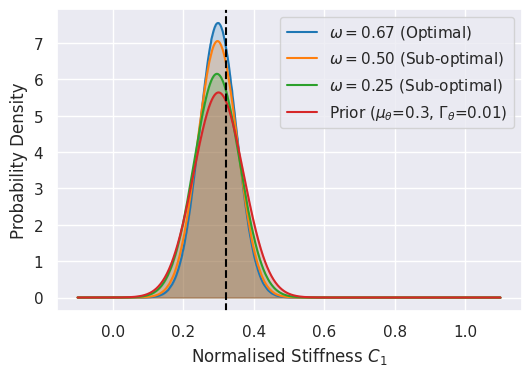

In [36]:
theta_plot = np.linspace(-0.1, 1.1, 1000).reshape(-1,1)
pdfs = {f'Prior ($\mu_\\theta$={prior_mean:.1f}, $\Gamma_\\theta$={prior_cov:.2f})': jnp.exp(prior.logpdf(theta_plot)['logpdf']),
        f'$\omega = {v_suboptimal_d:.2f}$ (Sub-optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, 
                                                                               v_suboptimal_y, v_suboptimal_d)['logpdf']),
        f'$\omega = {suboptimal_d:.2f}$ (Sub-optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, suboptimal_y, suboptimal_d)['logpdf']),
        f'$\omega = {optimal_d:.2f}$ (Optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, optimal_y, optimal_d)['logpdf'])}
pdfs = dict(reversed(list(pdfs.items())))
plotting_helpers.plot_distributions(pdfs, theta_plot, xlabel='Normalised Stiffness $C_1$')
ax = plt.gca()
plt.axvline(x=true_theta, color='black', linestyle='--')
plt.savefig(os.path.join(fig_save_dir, 'suboptimal_correct_prior.png'), dpi=mpl_save_dpi)

In [37]:
# Summary statistics:
d_theta = theta_plot[1] - theta_plot[0]
theta = theta_plot.squeeze()
for key, pdf_i in pdfs.items():
    pdf_i = pdf_i.squeeze()
    mean = np.sum(d_theta*pdf_i*theta)
    var = np.sum(d_theta*pdf_i*(theta-mean)**2)
    mode = theta_plot[np.argmax(pdf_i)]
    print(f'{key} distribution: Mean = {mean}, Mode = {mode}, Variance = {var}')

$\omega = 0.67$ (Optimal) distribution: Mean = 0.2984411418437958, Mode = [0.2987988], Variance = 0.0027908787596970797
$\omega = 0.50$ (Sub-optimal) distribution: Mean = 0.2970041334629059, Mode = [0.2975976], Variance = 0.0031975568272173405
$\omega = 0.25$ (Sub-optimal) distribution: Mean = 0.2954480051994324, Mode = [0.2951952], Variance = 0.004202555399388075
Prior ($\mu_\theta$=0.3, $\Gamma_\theta$=0.01) distribution: Mean = 0.30000004172325134, Mode = [0.3], Variance = 0.004999999422580004


## Under an 'Incorrect' Prior

What about a scenario where our prior is misspecified? Same code as before, but we set a specific true_theta value:

In [17]:
true_theta = 0.6
noise_cov = 0.005
prior_mean = 0.3
prior_cov = 0.005
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, noise_cov, 
                                                                           prior_mean, prior_cov)
v_suboptimal_d = 0.25
suboptimal_d = 0.5
optimal_d = 0.67
v_suboptimal_y = likelihood.sample(true_theta, v_suboptimal_d, num_samples=1, rng=np.random.default_rng(np_seed))
suboptimal_y = likelihood.sample(true_theta, suboptimal_d, num_samples=1, rng=np.random.default_rng(np_seed))
optimal_y = likelihood.sample(true_theta, optimal_d, num_samples=1, rng=np.random.default_rng(np_seed))

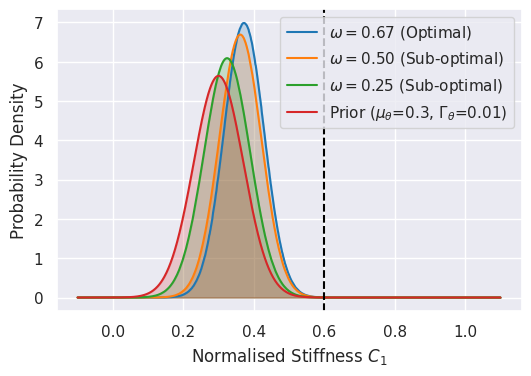

In [18]:
theta_plot = np.linspace(-0.1, 1.1, 1000).reshape(-1,1)
pdfs = {f'Prior ($\mu_\\theta$={prior_mean:.1f}, $\Gamma_\\theta$={prior_cov:.2f})': jnp.exp(prior.logpdf(theta_plot)['logpdf']),
        f'$\omega = {v_suboptimal_d:.2f}$ (Sub-optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, 
                                                                               v_suboptimal_y, v_suboptimal_d)['logpdf']),
        f'$\omega = {suboptimal_d:.2f}$ (Sub-optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, suboptimal_y, suboptimal_d)['logpdf']),
        f'$\omega = {optimal_d:.2f}$ (Optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, optimal_y, optimal_d)['logpdf'])}
pdfs = dict(reversed(list(pdfs.items())))
plotting_helpers.plot_distributions(pdfs, theta_plot, xlabel='Normalised Stiffness $C_1$')
ax = plt.gca()
plt.axvline(x=true_theta, color='black', linestyle='--')
plt.savefig(os.path.join(fig_save_dir, 'suboptimal_incorrect_prior.png'), dpi=mpl_save_dpi)

In [34]:
# Summary statistics:
d_theta = theta_plot[1] - theta_plot[0]
theta = theta_plot.squeeze()
for key, pdf_i in pdfs.items():
    pdf_i = pdf_i.squeeze()
    mean = np.sum(d_theta*pdf_i*theta)
    var = np.sum(d_theta*pdf_i*(theta-mean)**2)
    mode = theta_plot[np.argmax(pdf_i)]
    print(f'{key} distribution: Mean = {mean}, Mode = {mode}, Variance = {var}')

$\omega = 0.67$ (Optimal) distribution: Mean = 0.37232324481010437, Mode = [0.37327327], Variance = 0.0032608762849122286
$\omega = 0.50$ (Sub-optimal) distribution: Mean = 0.3617168664932251, Mode = [0.36246246], Variance = 0.003555207746103406
$\omega = 0.25$ (Sub-optimal) distribution: Mean = 0.32424262166023254, Mode = [0.32402402], Variance = 0.004288196563720703
Prior ($\mu_\theta$=0.3, $\Gamma_\theta$=0.01) distribution: Mean = 0.30000004172325134, Mode = [0.3], Variance = 0.004999999422580004
